# MiFID computation

Adapted from 'Demo MiFID metric for Dog image generation comp' (https://www.kaggle.com/wendykan/demo-mifid-metric-for-dog-image-generation-comp)

In [6]:
import os
import numpy as np
import pandas as pd 


from constants import DATA_PATH, RESULTS_PATH
print(os.listdir(DATA_PATH))

['monet_jpg', 'monet_tfrec', 'photo_jpg', 'photo_tfrec']


In [7]:
from __future__ import absolute_import, division, print_function
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 256,
        'output_layer': 'pool_3:0', 
        'input_layer': 'ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.compat.v1.gfile.GFile( pth, 'rb') as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.compat.v1.import_graph_def( graph_def, name='Pretrained_Net')

def _get_inception_layer(sess):
    """Prepares inception net for batched usage and returns pool_3 layer. 
       Adapted from https://github.com/bioinf-jku/TTUR/issues/6#issuecomment-388902304"""
    layername = 'pool_3:0'
    pool3 = sess.graph.get_tensor_by_name(layername)
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
                new_shape = []
                for j, s in enumerate(shape):
                    if s == 1 and j == 0:
                        new_shape.append(None)
                    else:
                        new_shape.append(s)
                o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return pool3

def get_activations(images, sess, model_name, batch_size=1, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_inception_layer(sess)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images // batch_size + 1 * (n_images % batch_size != 0)
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1, model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    print('covmean.shape=',covmean.shape)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def calculate_activation_statistics(images, sess, model_name, batch_size=64, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None):
    ''' Calculates the KID of two paths. '''
    tf.compat.v1.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = False)
        if feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance


In [8]:
tf.debugging.set_log_device_placement(True)

images_path = [RESULTS_PATH+'notebook_150_600_7000/',DATA_PATH+'monet_jpg/']

model_path = '../models/classify_image_graph_def.pb'

fid_epsilon = 10e-15
with tf.device('/GPU:0'):
    fid_value_public, distance = calculate_kid_given_paths(images_path, 'Inception', model_path)
    distance_thresh = distance_thresholding(distance, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance, "distance thresholded", distance_thresh, "multiplied_public: ", fid_value_public /(distance_thresh + fid_epsilon))


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


m1,m2 shape= ((2048,), (2048,)) s1,s2= ((2048, 2048), (2048, 2048))
starting calculating FID
covmean.shape= (2048, 2048)
done with FID, starting distance calculation
d.shape= (7038, 300)
np.min(d, axis=1).shape= (7038,)
distance= 0.23662488801256065
FID_public:  79.86430708622586 distance_public:  0.23662488801256065 distance thresholded 1 multiplied_public:  79.86430708622507


* A very bad notebook: 302.131 instead of 285.07819
* Input images: 117.558 instead of 78.96105
* Simple Cycle GAN: 85.468 instead of 49.37787
* Best notebook: 73.887 instead of 38.38419

In [9]:
print(round(302.131 / 285.07819, 3), round(302.131 - 285.07819, 3))
print(round(117.558 / 78.96105, 3), round(117.558 - 78.96105, 3))
print(round(85.468 / 49.37787, 3), round(85.468 - 49.37787, 3))
print(round(73.887 / 38.38419, 3), round(73.887 - 38.38419, 3))

1.06 17.053
1.489 38.597
1.731 36.09
1.925 35.503


notebook_100_600_14000: 79.86431158679329

notebook_150_600_7000:  79.864311480927

AttributeError: 'AxesSubplot' object has no attribute 'rcParams'

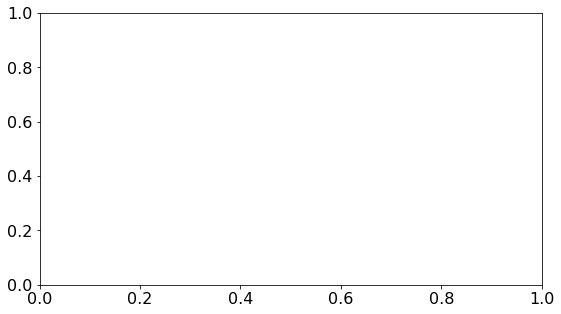

In [14]:
import matplotlib.pyplot as plt
bar_width = 0.2

x = np.array([0,1,2,3])

fig, ax = plt.subplots(figsize=(9, 5))
ax.rcParams['font.size'] = '16'
ax.bar([0, 1, 2, 3], [285.07819, 78.96105, 49.37787, 38.3841], width=bar_width, label="Kaggle MiFID")
ax.bar(x + bar_width, [302.131, 117.558, 85.468, 73.887], width=bar_width, label="Locally computed MiFID")
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(x)
ax.legend()
ax.savefig("mifid.pdf")